<a href="https://colab.research.google.com/github/Senion-Sharma/Handwritten-text-extractor/blob/main/Handwritten%20Text%20training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [3]:
import keras
print(keras.__version__)

1.2.2


Using TensorFlow backend.


In [4]:
from __future__ import division
import numpy as np
import os
import glob
from random import *
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
# %matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop
from google.colab import drive

In [5]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
d = {}
from subprocess import check_output
with open('gdrive/My Drive/data_subset/forms_for_parsing.txt') as f:
  for line in f:
    key = line.split(' ')[0]
    writer = line.split(' ')[1]
    d[key] = writer
print(len(d.keys()))

1539


In [7]:
tmp = []
target_list = []
path_to_files = os.path.join('/content/gdrive/My Drive/data_subset/data_subset','*')
for filename in sorted(glob.glob(path_to_files)):
  # print(filename)
  tmp.append(filename)
  image_name = filename.split('/')[-1]
  file, ext = os.path.splitext(image_name)
  parts = file.split('-')
  form = parts[0] + '-' + parts[1]
  for key in d:
    if key == form:
      target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


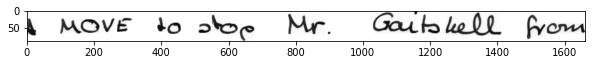

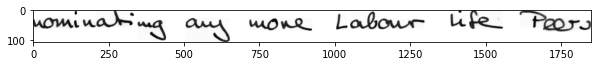

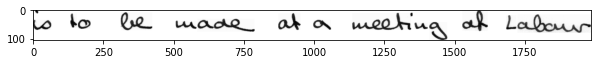

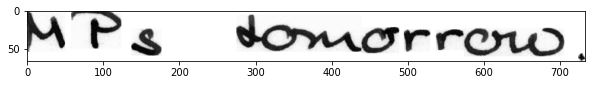

In [8]:
for filename in img_files[:4]:
  img=mpimg.imread(filename)
  plt.figure(figsize=(10,10))
  plt.imshow(img, cmap ='gray')

In [9]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:10], img_targets[:10], encoded_Y[:10])

['/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s00-00.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s00-01.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s00-02.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s00-03.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s01-00.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s01-01.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s01-02.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-000u-s01-03.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-003u-s00-00.png'
 '/content/gdrive/My Drive/data_subset/data_subset/a01-003u-s00-01.png'] ['000' '000' '000' '000' '000' '000' '000' '000' '000' '000'] [0 0 0 0 0 0 0 0 0 0]


In [10]:
train_files, rem_files, train_targets, rem_targets = train_test_split(img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)
validation_files, test_files, validation_targets, test_targets = train_test_split(rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [11]:
batch_size = 16
num_classes = 50
def generate_data(samples, target_files, batch_size=batch_size, factor = 0.1 ):
  num_samples = len(samples)
  from sklearn.utils import shuffle
  while 1: # Loop forever so the generator never terminates
    for offset in range(0, num_samples, batch_size):
      batch_samples = samples[offset:offset+batch_size]
      batch_targets = target_files[offset:offset+batch_size]
      images = []
      targets = []
      for i in range(len(batch_samples)):
        batch_sample = batch_samples[i]
        batch_target = batch_targets[i]
        im = Image.open(batch_sample)
        cur_width = im.size[0]
        cur_height = im.size[1]
        # print(cur_width, cur_height)
        height_fac = 113 / cur_height
        new_width = int(cur_width * height_fac)
        size = new_width, 113
        imresize = im.resize((size), Image.ANTIALIAS) # Resize so height = 113 now_width = imresize.size[0]
        now_height = imresize.size[1]
        # Generate crops of size 113x113 from this resized image and keep random avail_x_points = list(range(0, now_width - 113 ))# total x start points # Pick random x%
        pick_num = int(len(avail_x_points)*factor)
        # Now pick
        random_startx = sample(avail_x_points, pick_num)
        for start in random_startx:
          imcrop = imresize.crop((start, 0, start+113, 113))
          images.append(np.asarray(imcrop))
          targets.append(batch_target)
      # trim image to only see section with road
      X_train = np.array(images)
      y_train = np.array(targets)
      #reshape X_train for feeding in later
      X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
      #convert to float and normalize
      X_train = X_train.astype('float32')
      X_train /= 255
      #One hot encode y
      y_train = to_categorical(y_train, num_classes)
      yield shuffle(X_train, y_train)

In [12]:
# For training and testing, generator function is called with the intent of making train 
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor=0.3) 
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor=0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor=0.1)

In [15]:
def resize_image(image):
  return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))
# Resise data within the neural network
model.add(Lambda(resize_image)) #resize images to allow for easy computation

#model.add(Lambda(lambda x: resize_image))
# CNN model - Building the model suggested in paper
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))
model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))
model.add(Convolution2D(filters=128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, name='dense1')) #1024

# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, name='dense2')) #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax')) #softmax since output is within 50 classes
print("Worked till here")
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())

TypeError: ignored

In [15]:
nb_epoch = 4
samples_per_epoch = 233
nb_val_samples = 62
# #save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="gdrive/My Drive/data_subset/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]
# #Model fit generator
history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch, validation_data=validation_generator, nb_val_samples=nb_val_samples, nb_epoch=nb_epoch,verbose=1, callbacks=callbacks_list)

RuntimeError: ignored